In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/inv.csv',index_col= 'ds',parse_dates=True)
data.head()
data.asfreq('D')

,y
ds,


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 555 entries, 2018-12-01 to 2017-05-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       555 non-null    int64
dtypes: int64(1)
memory usage: 28.7 KB


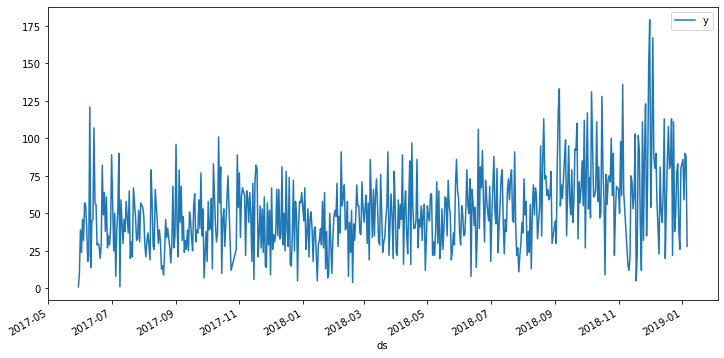

In [5]:
data.plot(figsize=(12,6))

In [6]:
len(data)

555

In [7]:
train = data.iloc[:543]
test = data.iloc[543:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
data.head(),data.tail()

(              y
 ds             
 2018-12-01  179
 2018-12-04  167
 2018-11-30  148
 2018-11-05  136
 2018-09-05  133,             y
 ds           
 2017-12-27  5
 2018-01-15  5
 2018-02-18  4
 2017-07-09  1
 2017-05-30  1)

In [11]:
scaler.fit(train)

MinMaxScaler()

In [12]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
scaled_train[:10]

array([[1.        ],
       [0.92941176],
       [0.81764706],
       [0.74705882],
       [0.72941176],
       [0.71764706],
       [0.7       ],
       [0.67058824],
       [0.65882353],
       [0.64705882]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generater
n_input = 3
n_feature = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input, batch_size=1)

In [16]:
X,y = generator[0]
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the array: 
[1.         0.92941176 0.81764706]
Predict this y: 
[[0.74705882]]


In [17]:
X.shape

(1, 3, 1)

In [18]:
# for 12 months 
n_input = 12 
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input, batch_size=1)


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [20]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(generator,epochs =50)

Epoch 1/50
531/531 [==============================] - 4s 6ms/step - loss: 0.0035
Epoch 2/50
531/531 [==============================] - 3s 5ms/step - loss: 1.1570e-04
Epoch 3/50
531/531 [==============================] - 3s 6ms/step - loss: 9.1847e-05
Epoch 4/50
531/531 [==============================] - 3s 6ms/step - loss: 9.3198e-05
Epoch 5/50
531/531 [==============================] - 3s 6ms/step - loss: 7.4487e-05
Epoch 6/50
531/531 [==============================] - 3s 6ms/step - loss: 7.0118e-05
Epoch 7/50
531/531 [==============================] - 3s 6ms/step - loss: 8.3560e-05
Epoch 8/50
531/531 [==============================] - 3s 6ms/step - loss: 4.4060e-05
Epoch 9/50
531/531 [==============================] - 3s 6ms/step - loss: 5.1036e-05
Epoch 10/50
531/531 [==============================] - 3s 6ms/step - loss: 8.0283e-05
Epoch 11/50
531/531 [==============================] - 3s 5ms/step - loss: 4.2866e-05
Epoch 12/50
531/531 [==============================] - 3s 6ms/step 

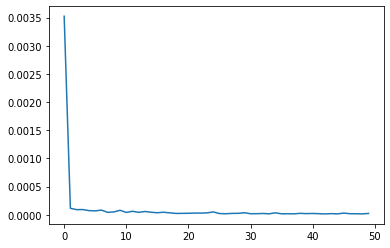

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-12:]

In [25]:
last_train_batch = last_train_batch.reshape((1,n_input,n_feature))


In [26]:
model.predict(last_train_batch)

array([[0.00187808]], dtype=float32)

In [27]:
scaled_test[0]

array([-0.00588235])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_feature))

for i in range(len(test)):
   current_pred = model.predict(current_batch)[0]
   test_predictions.append(current_pred)
   current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [29]:
test_predictions

[array([0.00187808], dtype=float32),
 array([0.00161597], dtype=float32),
 array([0.00137138], dtype=float32),
 array([0.00117011], dtype=float32),
 array([0.00100078], dtype=float32),
 array([0.00086331], dtype=float32),
 array([0.00074495], dtype=float32),
 array([0.00063633], dtype=float32),
 array([0.00054668], dtype=float32),
 array([0.00047079], dtype=float32),
 array([0.00041115], dtype=float32),
 array([0.00035229], dtype=float32)]

In [30]:
test.head()

,y
ds,
2018-06-12,8
2018-02-14,8
2017-07-05,8
2017-09-28,7
2018-01-25,7


In [31]:
true_preditions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_preditions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


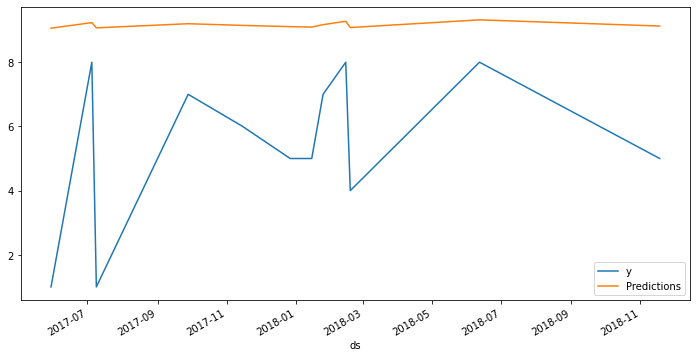

In [33]:
test.plot(figsize=(12,6))

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme = sqrt(mean_squared_error(test['y'],test['Predictions']))
print(rsme)

4.386371046553778


ARIMA

In [35]:
data.head()

,y
ds,
2018-12-01,179
2018-12-04,167
2018-11-30,148
2018-11-05,136
2018-09-05,133


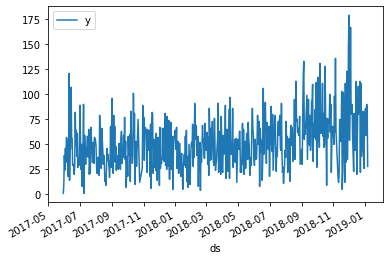

In [36]:
data.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


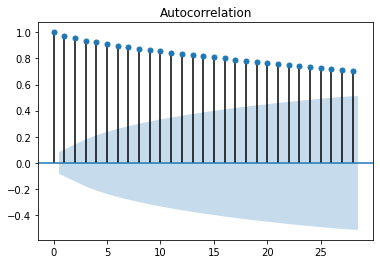

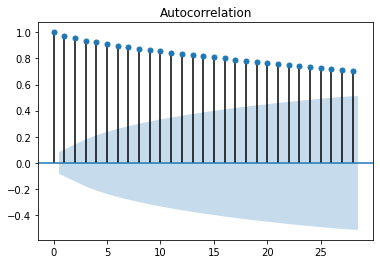

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)

In [38]:
data_diff = data.diff(periods=1)
data_diff

,y
ds,
2018-12-01,NaN
2018-12-04,-12.0
2018-11-30,-19.0
2018-11-05,-12.0
2018-09-05,-3.0
...,...
2017-12-27,0.0
2018-01-15,0.0
2018-02-18,-1.0


In [39]:
data_diff = data_diff[1:]
data_diff.head()

,y
ds,
2018-12-04,-12.0
2018-11-30,-19.0
2018-11-05,-12.0
2018-09-05,-3.0
2018-10-06,-2.0


In [40]:
data_diff.shape

(554, 1)

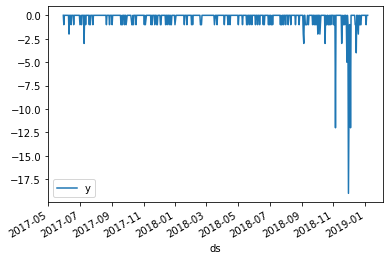

In [41]:
data_diff.plot()

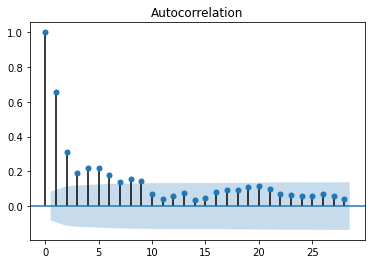

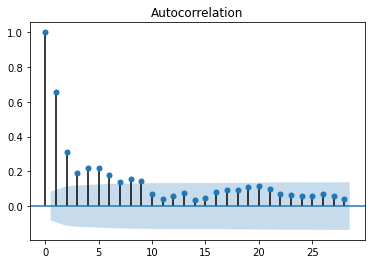

In [42]:
plot_acf(data_diff)

In [43]:
X = data.values
X.shape

(555, 1)

In [44]:
X

array([[179],
       [167],
       [148],
       [136],
       [133],
       [131],
       [128],
       [123],
       [121],
       [119],
       [117],
       [113],
       [113],
       [113],
       [112],
       [111],
       [111],
       [111],
       [110],
       [108],
       [107],
       [106],
       [103],
       [102],
       [101],
       [100],
       [ 99],
       [ 98],
       [ 97],
       [ 96],
       [ 95],
       [ 95],
       [ 94],
       [ 93],
       [ 93],
       [ 92],
       [ 92],
       [ 92],
       [ 91],
       [ 91],
       [ 91],
       [ 90],
       [ 90],
       [ 90],
       [ 90],
       [ 89],
       [ 89],
       [ 89],
       [ 88],
       [ 88],
       [ 88],
       [ 87],
       [ 86],
       [ 86],
       [ 86],
       [ 86],
       [ 86],
       [ 85],
       [ 85],
       [ 84],
       [ 83],
       [ 83],
       [ 83],
       [ 83],
       [ 82],
       [ 82],
       [ 81],
       [ 81],
       [ 81],
       [ 81],
       [ 81],
      

In [45]:
train = X[0:440]  # 80% for training
test = X[440:] # 20% for testing
predictions = []

In [46]:
train.size

440

AUTO REGRESSIVE MODEL 

In [47]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [48]:
predictions = model_ar_fit.predict(start=440,end=554)
predictions

array([28.85299967, 28.78785937, 28.73652976, 28.75605033, 28.6242553 ,
       28.58033807, 28.42603158, 28.43854652, 28.46563203, 28.40202104,
       28.38577403, 28.34410762, 28.29518873, 28.23435734, 28.22077488,
       28.19118931, 28.17340033, 28.1181505 , 28.08868747, 28.06119642,
       28.03867294, 28.02694154, 27.98936514, 27.96536085, 27.93672287,
       27.90836958, 27.88253223, 27.86782379, 27.84310556, 27.81914801,
       27.79361313, 27.77095235, 27.75299147, 27.73065348, 27.71182501,
       27.68868191, 27.66760087, 27.64692517, 27.62713107, 27.60787391,
       27.58992749, 27.56969189, 27.54944962, 27.53098892, 27.5120457 ,
       27.49446714, 27.47575333, 27.4576368 , 27.43923535, 27.42113832,
       27.40352273, 27.38619791, 27.36886086, 27.3515503 , 27.334184  ,
       27.31684229, 27.30023098, 27.2833915 , 27.26681576, 27.25019902,
       27.23366313, 27.21728052, 27.20103494, 27.18497873, 27.16900445,
       27.15307802, 27.13718495, 27.12146397, 27.10580471, 27.09

In [49]:
test

array([[29],
       [29],
       [29],
       [29],
       [29],
       [28],
       [28],
       [28],
       [28],
       [28],
       [28],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [23],
       [23],
       [23],
       [23],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [21],
       [21],
       [21],
       [21],
       [21],
       [20],
       [20],
       [20],
       [20],
       [20],
       [20],
       [19],
       [19],
       [19],
       [18],
       [18],
       [18],
       [18],
       [18],
       [17],

In [50]:
mean_squared_error(test,predictions)

109.5312253832854

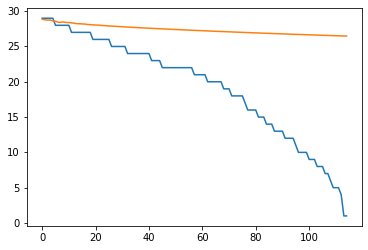

In [51]:
plt.plot(test)
plt.plot(predictions)

ARIMA

In [52]:
from statsmodels.tsa.arima_model import ARIMA


In [53]:
import itertools
p=d=q=range(0,9)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (0, 6, 7),
 (0, 6, 8),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 7, 4),
 (0, 7, 5),
 (0, 7, 6),
 (0, 7, 7),
 (0, 7, 8),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0, 8, 3),
 (0, 8, 4),
 (0, 8, 5),
 (0, 8, 6),
 (0, 8, 7),
 (0, 8, 8),
 (1, 0, 0),
 (1, 0, 1),
 (1,

In [54]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 4021.3299766454006
(0, 0, 1) 3439.4563765043104
(0, 0, 2) 2925.979981029008
(0, 0, 4) 2187.9454343733105
(0, 0, 5) 1929.882559733286
(0, 0, 6) 1779.6739869867922
(0, 0, 7) 1631.3730797318321
(0, 0, 8) 1564.424081685869
(0, 1, 0) 1493.4931588401885
(0, 1, 1) 1245.3515101301514
(0, 1, 6) 1137.3242465556305
(0, 1, 8) 1124.0880857943844
(0, 2, 0) 1153.3233516246096
(0, 2, 1) 1124.345647865341
(0, 2, 2) 1100.4403187683997
(0, 2, 3) 1102.1270544909028
(0, 2, 4) 1088.7734896569748
(0, 2, 5) 1048.7881410594043
(0, 2, 6) 1046.9557358211277
(0, 2, 7) 1047.7226313117735
(0, 2, 8) 1047.4708649587078
(1, 0, 0) 1535.3858377322117
(1, 0, 1) 1277.9017457133996
(1, 0, 2) 1190.6660229762306
(1, 0, 3) 1177.561673424091
(1, 0, 4) 1178.1303186462571
(1, 0, 5) 1166.668961862357
(1, 0, 6) 1157.1950539922514
(1, 0, 7) 1145.3625458738811
(1, 0, 8) 1143.2437920410416
(1, 1, 0) 1134.1660699666688
(1, 1, 1) 1132.3330564099238
(1, 1, 2) 1108.9965200150891
(1, 1, 3) 1110.5372353122739
(1, 2, 0) 1140.19063

In [64]:
model_arima = ARIMA(train,order=(3,0,0))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)
predictions = model_arima_fit.forecast(steps=115)[1]
predictions

1154.4466060753984


array([ 0.87714665,  1.82053247,  2.89249   ,  4.04968456,  5.263398  ,
        6.51322715,  7.78420274,  9.06509691, 10.34737536, 11.6245048 ,
       12.89147306, 14.14444405, 15.38050249, 16.59746074, 17.79370999,
       18.96810402, 20.11986727, 21.24852155, 22.35382707, 23.43573485,
       24.49434795, 25.52988991, 26.54267898, 27.53310691, 28.5016217 ,
       29.44871329, 30.37490198, 31.28072882, 32.16674787, 33.03351983,
       33.88160689, 34.71156859, 35.52395849, 36.31932157, 37.09819213,
       37.86109226, 38.60853063, 39.34100161, 40.05898472, 40.76294426,
       41.45332909, 42.13057262, 42.79509288, 43.44729272, 44.08756004,
       44.71626811, 45.33377594, 45.94042869, 46.53655806, 47.12248272,
       47.69850882, 48.26493039, 48.82202979, 49.3700782 , 49.90933604,
       50.44005343, 50.96247057, 51.47681821, 51.98331805, 52.48218308,
       52.97361802, 53.45781965, 53.93497717, 54.40527255, 54.86888082,
       55.32597042, 55.77670345, 56.221236  , 56.65971839, 57.09

In [65]:
test

array([[29],
       [29],
       [29],
       [29],
       [29],
       [28],
       [28],
       [28],
       [28],
       [28],
       [28],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [27],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [26],
       [25],
       [25],
       [25],
       [25],
       [25],
       [25],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [24],
       [23],
       [23],
       [23],
       [23],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [21],
       [21],
       [21],
       [21],
       [21],
       [20],
       [20],
       [20],
       [20],
       [20],
       [20],
       [19],
       [19],
       [19],
       [18],
       [18],
       [18],
       [18],
       [18],
       [17],

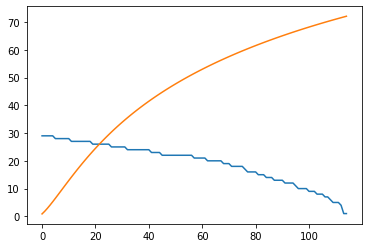

In [66]:
plt.plot(test)
plt.plot(predictions)

In [67]:
mean_squared_error(test,predictions)

1454.5017195157168